In this notebook we show how the CancerGrowthModel class is used, using examples and by providing some additional (background) information. The [readme](https://github.com/YamilaTimmer/dynamic-modelling-of-cancer/blob/main/README.md) contains instructions on how to use the class and this notebook can be used as a reference on how to interpret results/get examples of usage.

This class allows for predicting further tumor growth based on a provided dataset containing time in days and tumor volume in mm3. To do so it uses ODE (ordinary differential equations. For this example we will be using a dataset from the following source:

- S.S. Hassan & H.M. Al-Saedi, 2024 ("[Comparative Study of Tumor Growth Based on Single Species Models](https://www.bio-conferences.org/articles/bioconf/abs/2024/16/bioconf_iscku2024_00118/bioconf_iscku2024_00118.html)", BIO Web of Conferences 97, 00118)

We start out by plotting this data, so we can form some hypothesis on what type of growth takes place for the tumor.

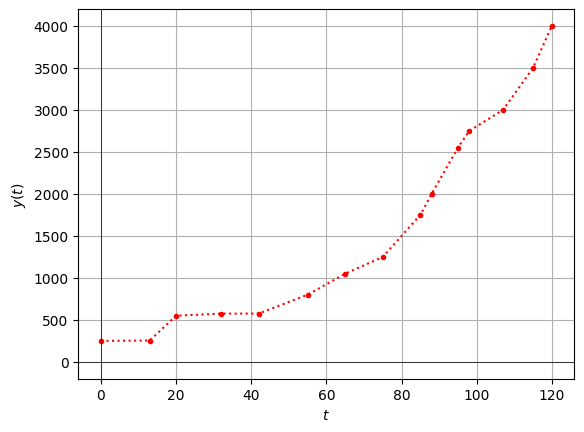

In [91]:
from matplotlib import pyplot as plt

ts_data = [0, 13, 20, 32, 42, 55, 65, 75, 85, 88, 95, 98, 107, 115, 120]
ys_data = [250, 255, 550, 575, 576, 800, 1050, 1250, 1750, 2000, 2550, 2750, 3000, 3500, 4000]

plt.plot(ts_data, ys_data, '.:r')
plt.axhline(0.0, lw=0.5, color='k'); plt.axvline(0.0, lw=0.5, color='k')
plt.grid(True)
plt.xlabel('$t$'); plt.ylabel('$y(t)$')
plt.show()

Looking at the data, we notice that not all t's are given, sometimes there might be several days to weeks in between two data points, however this is no issue as we still can grasp the general "shape" of the progression. The growth seems to start out relatively slow, but the speed seems to increase the further time progresses. For the available data there seems to be no slowing down of the speed again the higher the volume, this could indicate the tumor is not close to being its maximum size. ODE's that come to mind with this type of progression are for example exponential increase: $\frac{dV}{dt} = c\,V$ or mendelsohn: $\frac{dV}{dt} = c\,V^{d}$.

Now, after looking at the data we can import the CancerGrowthModel class to start fitting the ODE's onto the user-provided dataset. To do so, we use an ODE solver. An ODE describes how a quantity changes over time, which, in this case, is the volume of the tumor. Most ODE's can not be solved exactly, so they have to be approximated using an ODE solver. ODE solvers come in different types, where some might be more precise, but more complicated and others less precise and easier to implement. This class offers 3 different ODE solvers, [Heun's](https://en.wikipedia.org/wiki/Heun%27s_method), [Euler's](https://en.wikipedia.org/wiki/Euler_method) and [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (R4). The question the ODE solvers solve is: given a set of data points, what are the optimal values of parameters for this data? For the example we will use all three ODE solvers, to compare them, but feel free to just pick one as it is not necessary to use multiple.

In [92]:
from cancergrowthmodel import CancerGrowthModel as cgm

models = ["linear", "exponential_incr", "mendelsohn", "exponential_flat", "logistic",
          "montroll", "allee", "linear_limited", "surface_limited", "bertalanffy", "gompertz"]

solvers = ["heun", "euler", "runge-kutta"]

# Initial "guess" for everything is 0, as the variables are unknown
initial_guesses = {
    "linear":          {'c': 0.0, 'y0': 0.0},
    "exponential_incr":{'c': 0.0, 'y0': 0.0},
    "mendelsohn":      {'c': 0.0, 'a': 0.0, 'y0': 0.0},
    "exponential_flat":{'c': 0.0, 'ymax': 0.0, 'y0': 0.0},
    "logistic":        {'c': 0.0, 'ymax': 0.0, 'y0': 0.0},
    "montroll":        {'c': 0.0, 'ymax': 0.0, 'a': 0.0, 'y0': 0.0},
    "allee":           {'c': 0.0, 'ymin': 0.0, 'ymax': 0.0, 'y0': 0.0},
    "linear_limited":  {'c': 0.0, 'a': 0.0, 'y0': 0.0},
    "surface_limited": {'c': 0.0, 'a': 0.0, 'y0': 0.0},
    "bertalanffy":     {'c': 0.0, 'a': 0.0, 'y0': 0.0},
    "gompertz":        {'c': 0.0, 'ymax': 0.0, 'y0': 0.0},
}

all_params = {}
all_mse = {}

for solver in solvers:
    print("Solver: ", solver)
    params_dict = {}
    mse_dict = {}
    for model_type in models:
        params_0 = initial_guesses[model_type]
        model = cgm(model=model_type, ys_data=ys_data,ts_data=ts_data)

        params = model.search(params_0, search="pattern", solver=solver, tries=1000)
        params_dict[model_type] = params
        ts_fit, ys_fit = model.compute_curve(solver=solver, **params)
        mse = model.MSE(solver=solver, **params)
        mse_dict[model_type] = mse

        print(f'Optimal params {model_type}: {params}, mse: {mse}')
    all_params[solver] = params_dict
    all_mse[solver] = mse_dict

print(all_params)


Solver:  heun
Optimal params linear: {'c': 30.112436031272715, 'y0': -370.50402883649264}, mse: 175868.84934197634
Optimal params exponential_incr: {'c': 0.023089059073353162, 'y0': 255.07935291408631}, mse: 19025.89664223214
Optimal params mendelsohn: {'c': 5.338036041616075, 'a': 0.2808992049409583, 'y0': -0.19059286244204843}, mse: 63825.02151647804
Optimal params exponential_flat: {'c': 0.0, 'ymax': 301124373087.01666, 'y0': -370.5041021375525}, mse: 175868.8507452645
Optimal params logistic: {'c': 0.0, 'ymax': 296751775.20217085, 'y0': 1657.06665534921}, mse: 1439125.1149857342
Optimal params montroll: {'c': 0.0, 'ymax': 0.0, 'a': 0.0, 'y0': 1657.06665534921}, mse: 1439125.128888889
Optimal params allee: {'c': 0.0, 'ymin': 3948169.8647375274, 'ymax': 1.4963146768353248e-05, 'y0': 1.4963146768353251e-05}, mse: 200301.76545093762
Optimal params linear_limited: {'c': 32.84608565158302, 'a': 8.699164268883978e-05, 'y0': -0.0007173962941662278}, mse: 134667.19029345267
Optimal params s

Now we will plot some of the models with the lowest MSE. First we order the MSE_dict on item size from small to large.


In [93]:
sorted_mse_heun = sorted(all_mse["heun"].items(), key=lambda item: item[1])
sorted_mse_euler = sorted(all_mse["euler"].items(), key=lambda item: item[1])
sorted_mse_rk4 = sorted(all_mse["runge-kutta"].items(), key=lambda item: item[1])
print("Top three ODE's according to heun: ", sorted_mse_heun[:3])
print("Top three ODE's according to euler: ", sorted_mse_euler[:3])
print("Top three ODE's according to runge-kutta: ", sorted_mse_rk4[:3])

Top three ODE's according to heun:  [('exponential_incr', 19025.89664223214), ('surface_limited', 23838.182647520756), ('bertalanffy', 29130.09180891885)]
Top three ODE's according to euler:  [('exponential_incr', 19022.241780897966), ('surface_limited', 23648.052860428634), ('bertalanffy', 28221.434434806382)]
Top three ODE's according to runge-kutta:  [('exponential_incr', 19018.455780820106), ('surface_limited', 23841.38590767037), ('bertalanffy', 29148.928668119115)]


The top three best fitting ODE's for the provided data seem to be equal across all ODE solvers. However, do note that the MSE slightly varies among them, meaning the predicted optimal parameters also slightly differ. RK4 seems to have the lowest MSE for the number one ODE, being exponential_incr at 19018. Euler seems to have the lowest MSE for the second-best and third-best ODE, being surface_limited, with 23648 and bertalanffy with 28221. So even though Runge Kutta wins with lowest MSE for the number one ODE, it still performed worse for the second and third, where Euler seemed to be more accurate.

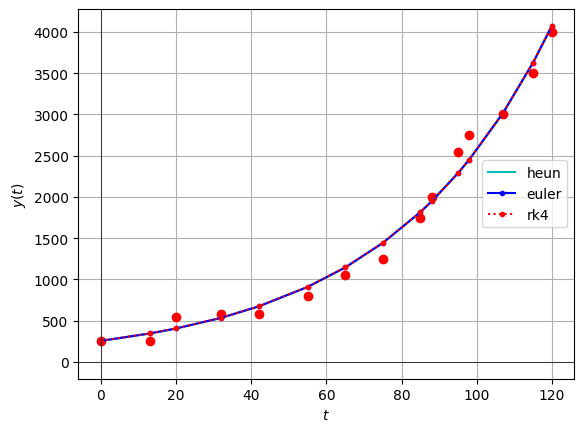

In [94]:
ts_list = []
ys_list = []

model_type = "exponential_incr"
params_heun = all_params["heun"][model_type]
params_euler = all_params["euler"][model_type]
params_rk4 = all_params["runge-kutta"][model_type]

# fitting ODE's to data
model = cgm(model=model_type, ys_data=ys_data,ts_data=ts_data)
ts_numer_1, ys_numer_1 = model.compute_curve(solver = "heun", **params_heun)
ts_numer_2, ys_numer_2 = model.compute_curve(solver = "euler", **params_euler)
ts_numer_3, ys_numer_3 = model.compute_curve(solver = "runge-kutta", **params_rk4)

# plot data
plt.plot(ts_data, ys_data, 'ro')
plt.plot(ts_numer_1, ys_numer_1, '-c', label="heun")
plt.plot(ts_numer_2, ys_numer_2, '.-b', label="euler")
plt.plot(ts_numer_3, ys_numer_3, '.:r', label="rk4")

plt.axhline(0.0, lw=0.5, color='k')
plt.axvline(0.0, lw=0.5, color='k')
plt.grid(True)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.show()

As we can see and as we already expected from the MSE only slightly differing across solvers, the outcomes for the predicted lines are near identical, providing that all ODE solvers provide a realistic result. Now that we have established this, we will move on using just RK4, as it had the lowest MSE for the best fitting ODE.

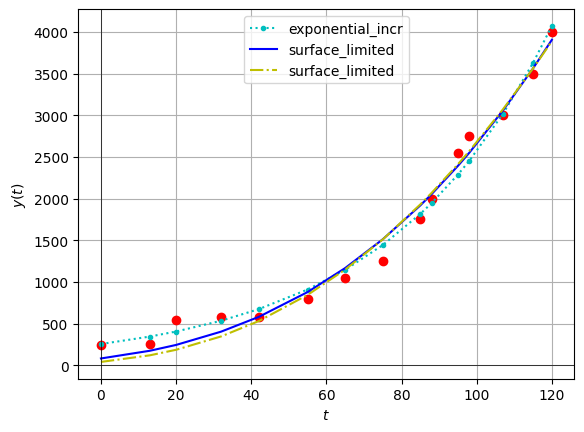

In [95]:
solver = "runge-kutta"
n_to_plot = 3

ts_list = []
ys_list = []

for i in range(n_to_plot):
    model_type = sorted_mse_rk4[i][0]
    params = all_params["runge-kutta"][model_type]

    model = cgm(model=model_type, ys_data=ys_data,ts_data=ts_data)
    ts_numer, ys_numer = model.compute_curve(solver = solver, **params)
    ts_list.append(ts_numer)
    ys_list.append(ys_numer)

# plot data
plt.plot(ts_data, ys_data, 'ro')
plt.plot(ts_list[0], ys_list[0], '.:c', label=sorted_mse_rk4[0][0])
plt.plot(ts_list[1], ys_list[1], '-b', label=sorted_mse_rk4[1][0])
plt.plot(ts_list[2], ys_list[2], '-.y', label=sorted_mse_rk4[1][0])

plt.axhline(0.0, lw=0.5, color='k')
plt.axvline(0.0, lw=0.5, color='k')
plt.grid(True)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.show()

As we saw earlier, the three best fitting ODE's (based on MSE) are exponential_incr, surface_limited and bertalanffy. Now having them plotted over the actual data it is clear that they nicely follow the progression of the actual data. However, other than ranking the best fitting ODE's on MSE, we can also use other comparison methods, including the BIC, AIC and AICc.

In [96]:
solver = "runge-kutta"

# Calculating/comparing scores
model_exp_incr = cgm(model="exponential_incr", ys_data=ys_data,ts_data=ts_data)
print("Score results expontential_incr:")
score_exp_incr = model_exp_incr.score(all_mse[solver]["exponential_incr"],
                                      all_params[solver]["exponential_incr"],
                                      solver=solver)

model_surf_limited = cgm(model="surface_limited", ys_data=ys_data,ts_data=ts_data)
print("Score results surface limited:")
score_surf_limited = model_surf_limited.score(all_mse[solver]["surface_limited"],
                                              all_params[solver]["surface_limited"],
                                              solver=solver)

model_bertalanffy = cgm(model="bertalanffy", ys_data=ys_data,ts_data=ts_data)
print("Score results bertalanffy:")
score_bertalanffy = model_bertalanffy.score(all_mse[solver]["bertalanffy"],
                                              all_params[solver]["bertalanffy"],
                                              solver=solver)

Score results expontential_incr:
BIC  = 153.2
AIC  = 151.8
AICc = 148.8
Score results surface limited:
BIC  = 159.3
AIC  = 157.2
AICc = 153.2
Score results bertalanffy:
BIC  = 162.3
AIC  = 160.2
AICc = 156.2


The BIC, AIC and AICc are strongly related to the MSE, the higher the MSE, the higher these scores. However, these scores take additional matters into account that MSE does not account for. For example the more parameters a model has, the more points it will get deducted from the score, as a model with too many parameters leads to overfitting. For all three scores, exponential_incr has the lowest, followed by surface_limited and lastly by bertalanffy. This is the same order as we had already concluded by looking at the MSE. If two models differ less than 2.0 on one of the scores, they can be viewed as equally well fitting, however all scores here seem to differ more than 2.0. _So the final conclusion would be that exponential_incr is the best fitting ODE for the data._

Now we can move on to predicting future growth, using the exponential_incr model.

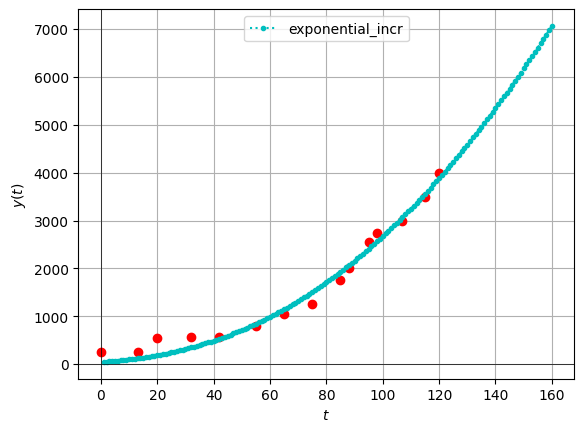

In [131]:
solver = "runge-kutta"

model_type = sorted_mse_rk4[i][0]
params = all_params["runge-kutta"][model_type]

ts_extended = list(range(0, 161))  # t= 0-160

params_fitted = all_params["runge-kutta"][model_type]
ts_predict, ys_predict = model.compute_curve(solver="runge-kutta", **params_fitted)

model = cgm(model=model_type, ys_data=ys_data,ts_data=ts_extended)
ts_numer, ys_numer = model.compute_curve(solver = solver, **params)

# plot data
plt.plot(ts_data, ys_data, 'ro')
plt.plot(ts_predict, ys_predict, '.:c', label=sorted_mse_rk4[0][0])

plt.axhline(0.0, lw=0.5, color='k')
plt.axvline(0.0, lw=0.5, color='k')
plt.grid(True)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.show()

Now we have plotted the predicted tumor growth from t=120 to t=160. Keep in mind an exponential ODE better describes tumors in early stages, and it does not keep into account any maximum physical size the tumor can increase to. A better suited model, where growth slows down after a certain period, would likely be the best fitted model if the data contained measurements over a longer period.